# Unsupervised Machine Learning Techniques II

### Local Outlier Factor

Anderson Nelson  <br>
Date: 11/10/2019 <br>

### Introduction

So far, I've experimented and studied linear models for outlier detection (PCA), outlier ensemble techniques (Isolation forest). This week I want to experiment with a new type of model proximity outlier detection (Local Outlier Factor). I'm still continuing with the 


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

C:\Users\ander\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# function used throughout the model 
def correlation_threshold(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset

def outlier_detection(data): 
    result = []
    for value in data: 
        if value == 0:
            result.append('Normal')
        else: 
            result.append('Outlier')
    return result

In [3]:
# Read data 
data = pd.read_csv('../Data/data.csv')
data = data.drop(columns = ['Unnamed: 0','Provider City','K Means 1'])

In [4]:
# filter data for columns with numerical values 
data_subset = data.iloc[:,7:]
data_subset_name = data_subset.columns

# normalized data to reduced the impact of variables on scale 
data_subset_scaled = StandardScaler().fit_transform(data_subset)
data_subset_scaled = pd.DataFrame(data_subset_scaled, columns=data_subset_name)

# any two columns with  correlation of more than 0.8 is removed from the data set, rational is to capture  that add additional value in the data 
model_data = correlation_threshold(data_subset_scaled, 0.8)
print(f' There are {len(model_data.columns)} columns remaining in the data')

 There are 21 columns remaining in the data


In [5]:
# split data based on the first 70% of rows in the data 
train_split_dim = data_subset.shape[0] * 0.6
train_data = data_subset_scaled.loc[1:train_split_dim]
test_data = data_subset_scaled.loc[train_split_dim:]

### Local Outlier Factor: 

Measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, the locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

There are several ways to tune the parameters of a LOF, and understanding the pros and cons of each approach, an in-depth understanding of the data produces the best results. After experimenting with a few parameters, I realize what parameters are a good fit for my data. 

LOF requires to estimate the proportion of the outlier that's in your data, calculates the variables that meet this threshold. This approach is fundamentally different from the previous methods I've experimented with. The default parameters are 0.1 for LOF; based on my guess, I'm assuming that less than 10% of providers are committing fraud, and I've decided to that further. 

In [6]:
# split data based on the first 70% of rows in the data 
train_split_dim = data_subset.shape[0] * 0.7
train_data = data_subset_scaled.loc[1:train_split_dim]
test_data = data_subset_scaled.loc[train_split_dim:]

# filter the main dataset and only includes that passets the correlation test 
X_test_cluster = data_subset.loc[train_split_dim:].copy()
X_test_cluster = X_test_cluster.loc[:, model_data.columns] # dataset used throuhght the document

# test subset 
test_subset = data.loc[train_split_dim:,model_data.columns]

### Model 1

Consistent the other models I've analyzed, average covered charges are higher in the outlier category by 2.36x, and out of pocket payment is higher for the outlier categories. At first, it didn't make sense to me that it would be that high for outliers; however, after giving it, some thought it occurred to me that for a hospital to be reimbursed by Medicare, there are numerous compensation and verification hurdles that the hospitals must meet. Those hurdles are costly to the hospital provider, the process can sometimes take months, and there's no guarantee that the hospital will be reimbursed. For the procedures that are more expensive, it represents a huge risk from the providers' standpoint. That risk can be a great incentive for providers to be persuaded to commit fraud. 

I also see that the providers' labels as outliers also have twice as many traffic as normal. Combined with the point stated earlier, There's a massive revenue collection risk, and cash flow delays that Medicare costs those providers.Given that the average medicare % paid is around the same for both th.e classes, my assumption is that since the providers overcharge for certain procedures, and reduces their risk by collecting a higher percentage upfront from customers. Those procedures tend to be an average more expensive.   

The first models produced: 1957 outliers, and providers labels as outliers follows some of the same patterns that I've seen in the previous examples. 

When comparing average covered charges with out of pocket payments, it's evident that the normal category has a defined range, Max covered charges of 400,000 and out of pocket payments of 15,000. The outlier category contains a higher variance.  For those variables that overlap, it indicates that there are other parameters that separate them. 

There are clear boundaries for the medicare % paid for the normal values, and medicare % paid to seem to be an import factor to distinguish between outliers and normal.

In [7]:
# train data
model_1 = LOF(n_neighbors=200,metric='euclidean',contamination=0.04)
model_1.fit(train_data)

LOF(algorithm='auto', contamination=0.04, leaf_size=30, metric='euclidean',
  metric_params=None, n_jobs=1, n_neighbors=200, p=2)

In [8]:
test_subset['LOF_1'] = model_1.fit_predict(test_data)
test_subset['LOF_1'] = outlier_detection(test_subset['LOF_1'])
test_subset['LOF_1'].value_counts()

Normal     35442
Outlier     1477
Name: LOF_1, dtype: int64

In [9]:
# mean of the the test subsgroup
round(test_subset.groupby('LOF_1').mean(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_1,,,,,,,,,,,,,,,,,,,,,
Normal,40960.53,11068.58,1369.85,3.79,58.06,0.32,0.85,41.98,11.12,1397.60,...,0.32,0.85,0.99,0.99,0.99,0.98,0.98,1.00,2.97,1.00
Outlier,72131.86,19447.47,2955.68,4.10,132.84,0.40,0.82,67.79,16.36,2292.68,...,0.40,0.84,1.29,1.26,1.17,1.36,1.48,1.05,2.74,0.98


In [10]:
# std of the test subgroup
round(test_subset.groupby('LOF_1').std(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_1,,,,,,,,,,,,,,,,,,,,,
Normal,34681.56,7848.67,1108.87,1.75,63.48,0.16,0.09,39.15,10.02,767.65,...,0.13,0.07,0.53,0.27,0.14,0.42,0.61,0.27,1.08,0.07
Outlier,77504.47,16616.61,4038.51,3.04,271.18,0.29,0.14,82.10,14.05,2112.59,...,0.23,0.09,1.27,0.62,0.33,1.10,1.68,0.61,1.58,0.15


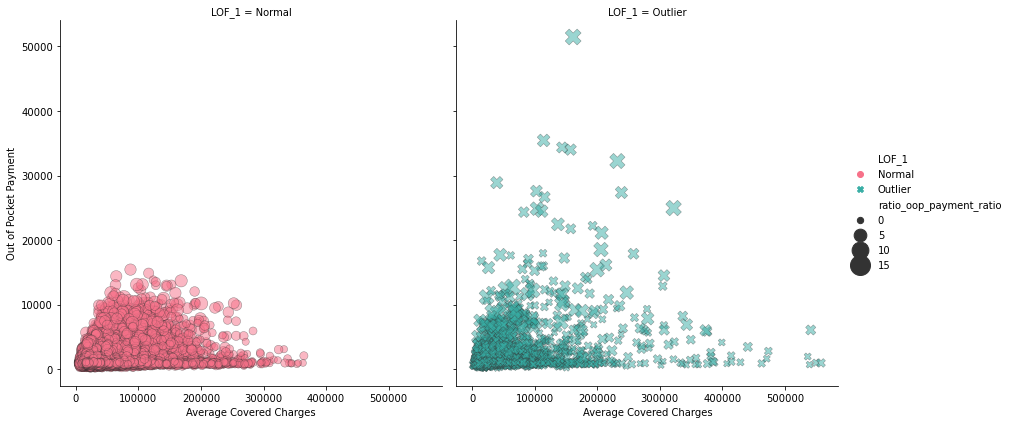

In [11]:
sns.relplot(x="Average Covered Charges", y="Out of Pocket Payment", col = "LOF_1",hue="LOF_1",style="LOF_1",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset, palette=sns.color_palette("husl", 2))
plt.show()

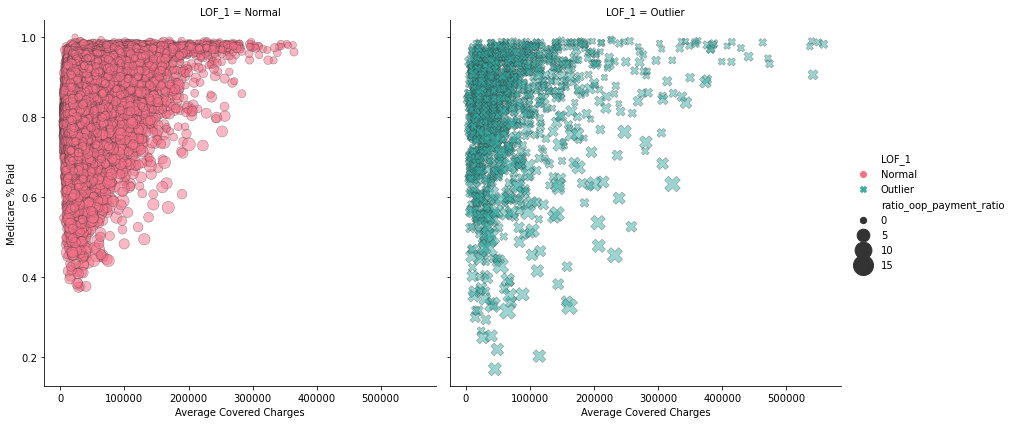

In [12]:
sns.relplot(x="Average Covered Charges", y="Medicare % Paid", col = "LOF_1",hue="LOF_1",style="LOF_1",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

### Model 2

For the second model, I wanted to dial down the number of samples used and observe the impact on the results. Similar to model 1, Averaged covered charges are about 2x higher in the outlier label. The covered charges standard deviation is less in the outliers of model 2 vs. model 1. 

Similar to model 1, visualizing the results highlights the concentration of the normal labels and variability of the outlier labels. 

In [13]:
# train data
model_2 = LOF(n_neighbors=50,contamination=0.05)
model_2.fit(train_data)

LOF(algorithm='auto', contamination=0.05, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=50, p=2)

In [14]:
test_subset['LOF_2'] = model_2.fit_predict(test_data)
test_subset['LOF_2'] = outlier_detection(test_subset['LOF_2'])
test_subset['LOF_2'].value_counts()

Normal     35073
Outlier     1846
Name: LOF_2, dtype: int64

In [15]:
# mean of the the test subsgroup
round(test_subset.iloc[:,3:].groupby('LOF_2').mean(),2)

,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,mean_oop_per_discharge_drg_state_region,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_2,,,,,,,,,,,,,,,,,,
Normal,3.79,58.48,0.32,0.85,42.0,11.14,1401.33,59.81,0.32,0.85,0.99,0.99,0.99,0.98,0.98,1.00,2.97,1.00
Outlier,4.01,109.96,0.39,0.82,62.3,15.03,2042.82,84.55,0.38,0.84,1.21,1.18,1.13,1.29,1.38,1.06,2.80,0.98


In [16]:
# std of the test subgroup
round(test_subset.groupby('LOF_2').std(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_2,,,,,,,,,,,,,,,,,,,,,
Normal,34568.23,7834.71,1128.15,1.75,65.89,0.16,0.09,39.79,10.03,796.71,...,0.13,0.07,0.54,0.28,0.14,0.42,0.61,0.27,1.08,0.07
Outlier,73127.00,15752.69,3605.87,2.87,235.58,0.27,0.13,69.67,13.44,1746.09,...,0.21,0.09,1.11,0.57,0.32,0.96,1.48,0.56,1.53,0.13


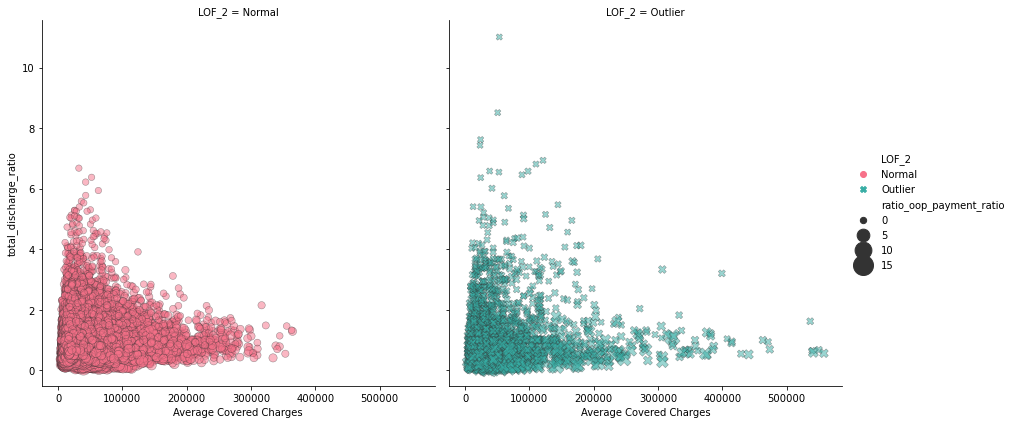

In [17]:
sns.relplot(x="Average Covered Charges", y="total_discharge_ratio", col = "LOF_2",hue="LOF_2",style="LOF_2",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

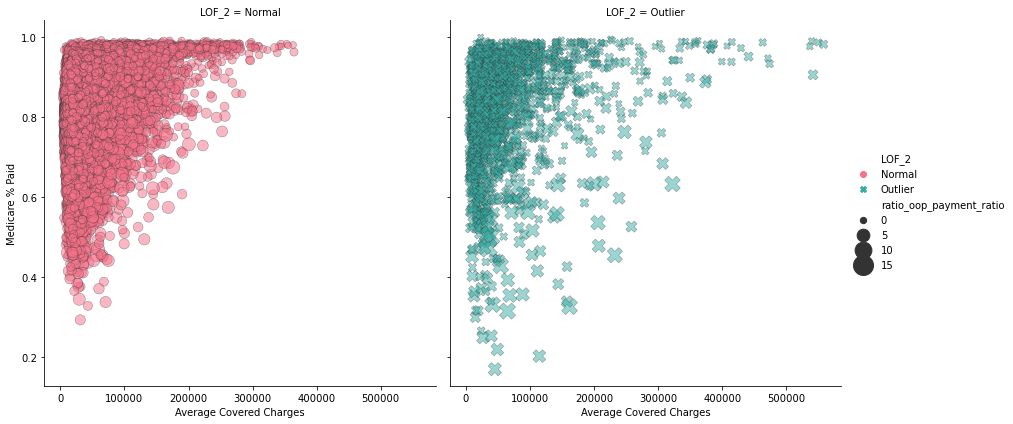

In [18]:
sns.relplot(x="Average Covered Charges", y="Medicare % Paid", col = "LOF_2",hue="LOF_2",style="LOF_2",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

### Model 3

In [19]:
# train data
model_3 = LOF(contamination=0.01,metric='l1')
model_3.fit(train_data)

LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='l1',
  metric_params=None, n_jobs=1, n_neighbors=20, p=2)

In [20]:
test_subset['LOF_3'] = model_3.fit_predict(test_data)
test_subset['LOF_3'] = outlier_detection(test_subset['LOF_3'])
test_subset['LOF_3'].value_counts()

Normal     36549
Outlier      370
Name: LOF_3, dtype: int64

In [21]:
# mean of the the test subsgroup
round(test_subset.groupby('LOF_3').mean(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_3,,,,,,,,,,,,,,,,,,,,,
Normal,41778.5,11275.13,1406.63,3.81,59.56,0.32,0.85,42.78,11.31,1422.60,...,0.32,0.85,1.00,1.00,1.00,0.99,0.99,1.0,2.97,1.00
Outlier,84593.1,24112.77,4067.36,3.66,208.30,0.46,0.80,65.77,13.69,2501.61,...,0.44,0.84,1.34,1.28,1.24,1.52,1.80,1.1,2.45,0.96


In [22]:
# std of the the test subsgroup
round(test_subset.groupby('LOF_3').std(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
LOF_3,,,,,,,,,,,,,,,,,,,,,
Normal,36436.00,8206.78,1205.29,1.8,68.98,0.16,0.09,41.45,10.22,843.46,...,0.13,0.07,0.56,0.29,0.15,0.45,0.65,0.29,1.1,0.07
Outlier,99876.04,21362.03,6487.28,3.1,457.61,0.35,0.17,77.57,13.17,2431.00,...,0.25,0.11,1.51,0.64,0.44,1.35,2.14,0.71,1.6,0.18


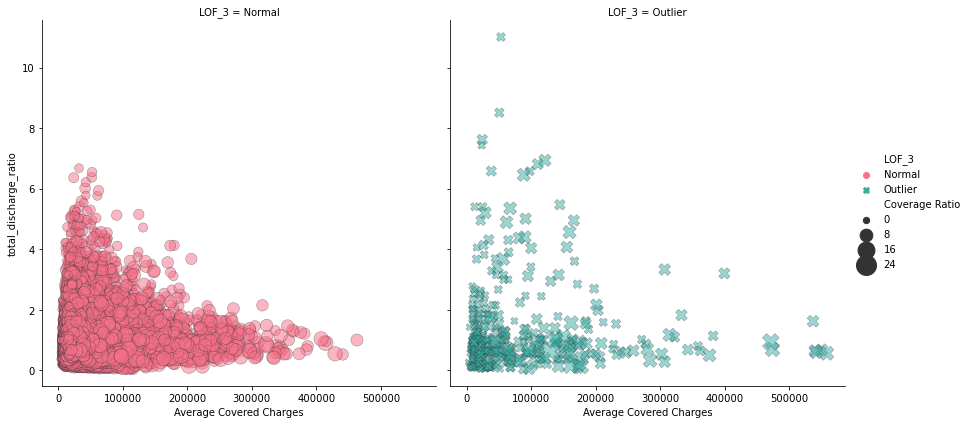

In [23]:
sns.relplot(x="Average Covered Charges", y="total_discharge_ratio", col = "LOF_3",hue="LOF_3",style="LOF_3",  size="Coverage Ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

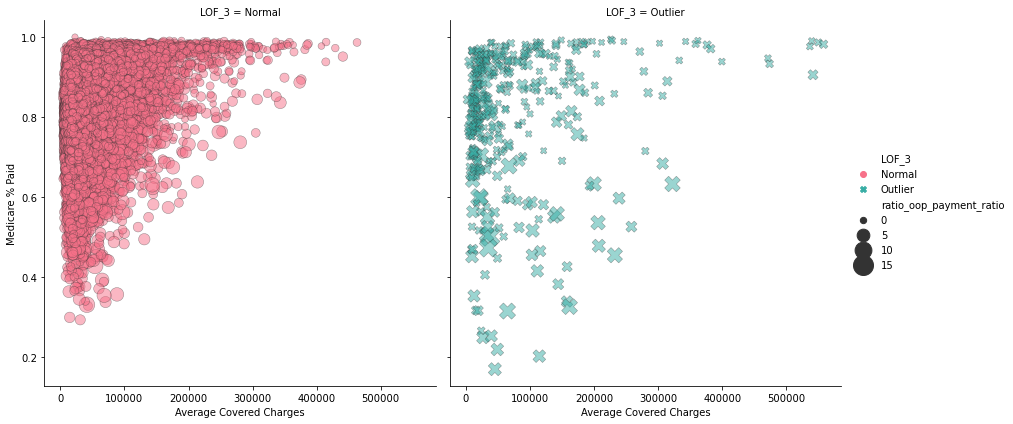

In [24]:
sns.relplot(x="Average Covered Charges", y="Medicare % Paid", col = "LOF_3",hue="LOF_3",style="LOF_3",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

## Evaluate models 

Utilizing only 1 model for your prediction can be dangerous, especially since it there's a lot of subjectivity in how the paramaters were determined. In this section I will combine the models using the average and maxium of maximum technique

### Average

In [25]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'Model_1': model_1.decision_function(train_data),
                             'Model_2': model_2.decision_function(train_data),
                             'Model_3': model_3.decision_function(train_data)
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'Model_1': model_1.decision_function(test_data),
                             'Model_2': model_2.decision_function(test_data),
                             'Model_3': model_3.decision_function(test_data) 
                            })

# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

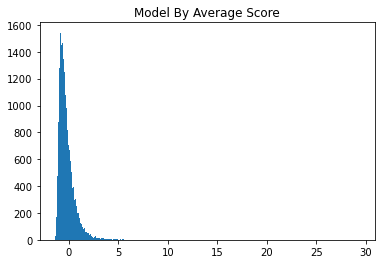

In [26]:
model_by_average = average(test_scores_norm)
plt.hist(model_by_average, bins='auto')
plt.title('Model By Average Score')
plt.show()

In [27]:
test_subset['Model_by_avg'] = np.where(model_by_average > 2, 'Oultier', 'Normal')
test_subset['Model_by_avg'].value_counts()

Normal     36136
Oultier      783
Name: Model_by_avg, dtype: int64

In [28]:
np.round(test_subset.groupby('Model_by_avg').mean(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
Model_by_avg,,,,,,,,,,,,,,,,,,,,,
Normal,41318.49,11179.11,1392.97,3.80,59.02,0.32,0.85,42.45,11.24,1412.48,...,0.32,0.85,0.99,0.99,1.0,0.99,0.99,1.00,2.97,1.00
Oultier,83239.91,21772.81,3294.00,4.14,154.61,0.42,0.82,68.84,15.58,2399.40,...,0.41,0.84,1.29,1.30,1.2,1.43,1.62,1.06,2.71,0.97


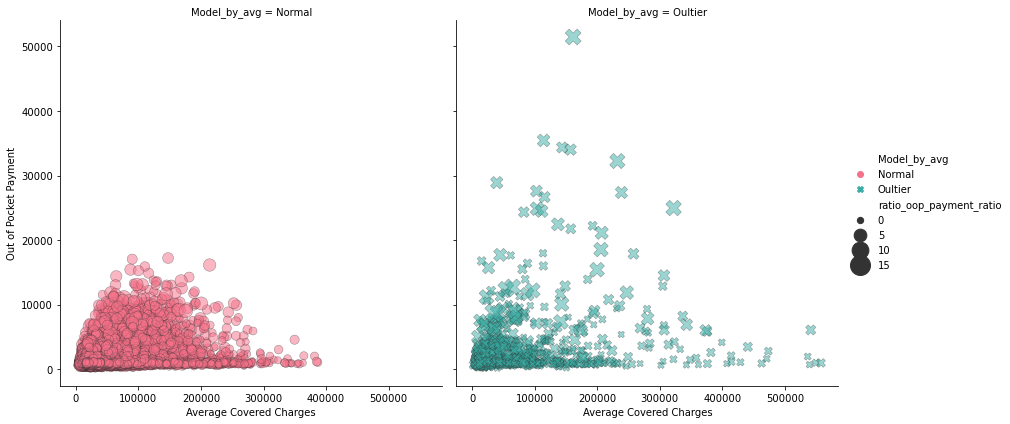

In [29]:
sns.relplot(x="Average Covered Charges", y="Out of Pocket Payment", col = "Model_by_avg",hue="Model_by_avg",style="Model_by_avg",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

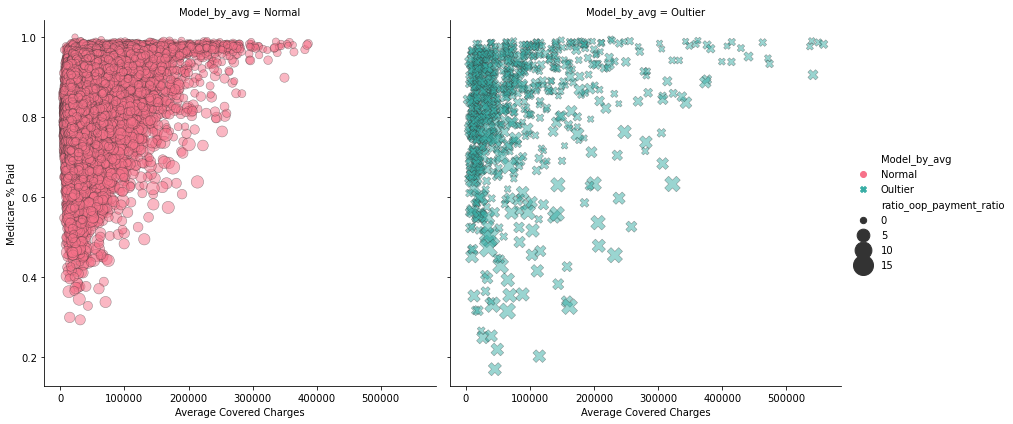

In [30]:
sns.relplot(x="Average Covered Charges", y="Medicare % Paid", col = "Model_by_avg",hue="Model_by_avg",style="Model_by_avg",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

### Maximum

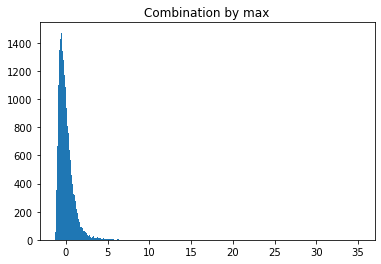

In [31]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
plt.hist(y_by_maximization, bins='auto')
plt.title("Combination by max")
plt.show()

In [32]:
test_subset['model_by_max'] = np.where(y_by_maximization<4, 'Normal', 'Outlier')
test_subset['model_by_max'].value_counts()

Normal     36630
Outlier      289
Name: model_by_max, dtype: int64

In [33]:
np.round(test_subset.groupby('model_by_max').mean(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
model_by_max,,,,,,,,,,,,,,,,,,,,,
Normal,41777.33,11282.59,1406.78,3.80,59.5,0.33,0.85,42.67,11.31,1419.81,...,0.33,0.85,1.0,1.00,1.00,0.99,0.99,1.00,2.97,1.00
Outlier,96740.59,26764.91,4793.27,4.01,258.1,0.45,0.79,85.77,14.55,3156.89,...,0.41,0.83,1.3,1.33,1.28,1.64,2.06,1.13,2.55,0.95


In [34]:
np.round(test_subset.groupby('model_by_max').std(),2)

,Average Covered Charges,Average Total Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_drg_state_region,...,mean_pmt_cov_pct_drg_state_region,mean_medicare_paid_state_region,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,Medicare Paid Ratio
model_by_max,,,,,,,,,,,,,,,,,,,,,
Normal,36459.63,8217.53,1202.52,1.80,68.54,0.16,0.09,40.68,10.23,824.12,...,0.13,0.07,0.56,0.29,0.15,0.44,0.65,0.29,1.10,0.07
Outlier,107294.12,22676.70,7207.34,3.53,513.46,0.38,0.19,118.58,13.41,3154.40,...,0.23,0.11,1.61,0.71,0.49,1.64,2.47,0.81,1.53,0.21


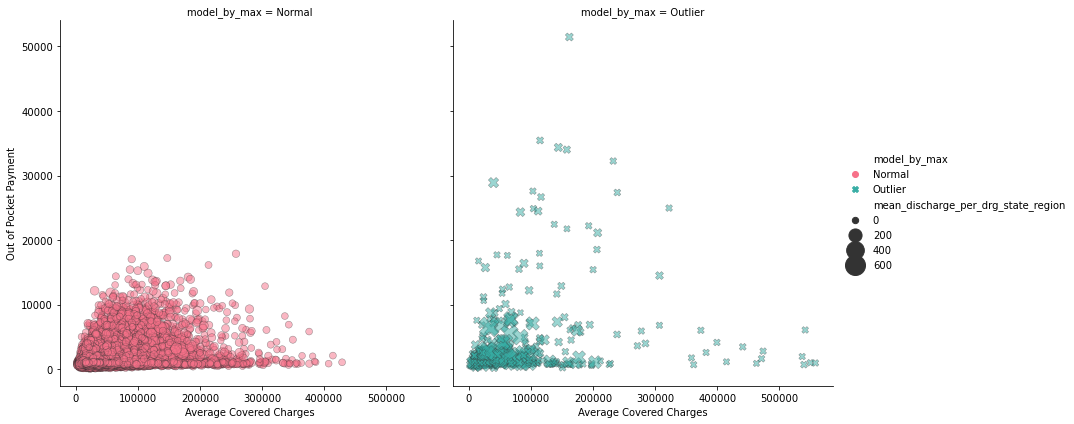

In [35]:
sns.relplot(x="Average Covered Charges", y="Out of Pocket Payment", col = "model_by_max",hue="model_by_max",style="model_by_max",  size="mean_discharge_per_drg_state_region",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

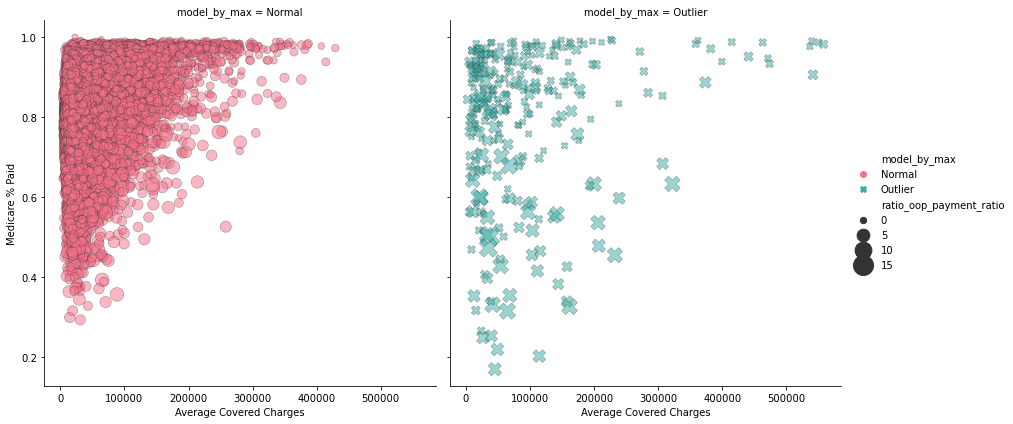

In [36]:
sns.relplot(x="Average Covered Charges", y="Medicare % Paid", col = "model_by_max",hue="model_by_max",style="model_by_max",  size="ratio_oop_payment_ratio",
            sizes=(40, 400),edgecolor=".2", linewidth=.5, alpha=.5,
            height=6, data=test_subset,palette=sns.color_palette("husl", 2))
plt.show()

### Conclusion: 

One of the critical lessons I learned in this analysis is balancing. Understanding the motives of the involved parties allows us to evaluate the results of the models and letting the model dictate the story. While the model can produce results that defy logic, however sometimes, it highlights the relationship that you didn't consider. Domain knowledge allows you to distinguish between the two classes.

Consistently, we have that the providers at the higher end of the pricing spectrum, and high out of pocket payments are identitfied as potential candidate for investigation. This behaviors can be explained by incentivized by the ineffeiceies of Medicare, providers can be incentivized to recover their cost upfront from cusotmer, and inflate procedure expenses.

Similar to last week, the LOF algorithm relies on me to be abie to correcty identify the paramters that captures the tru relationahip of the model. By combing different models, we are taking advantage of the wisdom of the crowd and reduce the reliance on one technique.

### Reference: 

[LOF: Identifying Density-Based Local Outliers](https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf)